# Notebook del TP 1: Business Case

En este Notebook implementaremos dos experimentos de la lista de experimentos. Estos son:


1.   La edad es el mayor predictor de ACV (Experimento 1)
2.   El género es un predictor de ACV según el rango etario (Experimento 5)


## Introducción: análisis exploratorio general



> Importamos todas las librerias necesarias para ML y manipulacion de datos



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Modifique esto según como lo guarde para poder abrir el csv:

In [ ]:
DATA_HOME = r"/content/gdrive/My Drive/UBA/machine learning/tp1"

In [ ]:
df = pd.read_csv(
    DATA_HOME + "/healthcare-dataset-stroke-data.csv"
)

Vemos la cantidad de variables: notemos que hay muchas variables categóricas y otras numéricas como edad, nivel de glucosa e índicice de masa corporal. También notamos que, salvo `bmi`, contamos con 5110 observaciones totales.

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.count() 

id                   5110
gender               5110
age                  5110
hypertension         5110
heart_disease        5110
ever_married         5110
work_type            5110
Residence_type       5110
avg_glucose_level    5110
bmi                  4909
smoking_status       5110
stroke               5110
dtype: int64


### Limpieza del dataset
Decidimos sacar a la única personas con género *Other* porque sería muy difícil de predecir y no aportaba valor al ser una sola observación con ese valor.

A su vez, al explorar la columna `bmi` (indice de masa corporal) vimos que muchos tenian `NA` como valor, por eso decidimos sacar aquellos datos faltantes del dataset a costa de perder un porcentaje chico de nuestros datos.

Por otro lado, en nuestro análisis notabamos que la `residencia` y el `work_type` no aportaban valor explicativo ni una relacion muy clara con los ACV y que eran features que se hacían presentes solo con overfitteo. Con lo cual quitarlas era algo que todos coincidimos.

Habra alguna relacion entre cada variable categorica y tener un ACV?
Hagamos un bar plot de porcentaje

In [ ]:
df = df[df.gender != "Other"]
df = df[df['bmi'].notna()]
df = df.drop(["work_type",	"Residence_type"], axis=1)

Veamos la proporición de los datos:

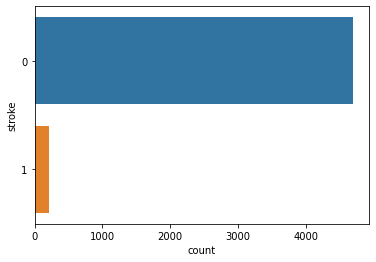

In [ ]:
sns.countplot(data=df, y='stroke')

Notamos que hay mucha más cantidad de personas sin ACV que con ACV en nuestra base de datos. Esto será importante a la hora de hacer los experimentos.

Para poder realizar un análisis de las variables categóricas es necesario pasarlas a una base de unos y ceros para que el clasificador pueda operar, o sea, aplicaremos el OneHotEncoding. En este caso lo haremos con género, si alguna vez estuvo casadx y su relacion con fumar.  

In [ ]:
categoricas = ["gender", "ever_married","smoking_status"]
dfEncodeada = pd.get_dummies(df, columns=categoricas, prefix=["gen","casad","smokstat"] )

### Divison del dataset
Por un lado sacamos la columna stroke que es la que buscamos predecir y la guardamos aparte.
ID la podemos sacar ya que no queremos que el identificador de personas sea una feature que se use para predecir en nuestro modelo. 

In [ ]:
dfEncodeada = dfEncodeada.loc[:, dfEncodeada.columns != "id"]
ydf = dfEncodeada["stroke"]
xdf = dfEncodeada.loc[:, dfEncodeada.columns != "stroke"]

## Experimento 1: La edad es el mayor predictor de riesgo.

¿Por qué nos importa la edad? Al realizar un análisis exploratorio, notamos que las personas con ACV sulen ser las personas mayores, para ello veamos la distribución de personas con ACV y sin ACV por edad: 

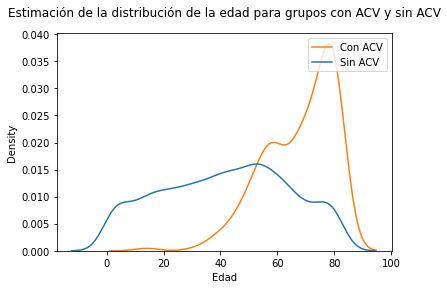

In [ ]:
fig1 = sns.kdeplot(data=df, x='age', hue='stroke', common_norm= False, legend=False)
plt.xlabel("Edad")
plt.title("Estimación de la distribución de la edad para grupos con ACV y sin ACV", y=1.05)
plt.legend(loc='upper right', labels=['Con ACV', 'Sin ACV'])
plt.show(fig1)

En este gráfico, notamos que la la distribución estimada para personas con ACV se consentra en un rango etario mayor. Nos preguntamos ahora cómo podemos verificar esto. Proponemos a continuación dos modelos: 


*   Decision Tree, la idea de usar un Decision Tree es que facilita la interpretabilidad del modelo.
*   Random Forest, corroboaremos que tanto como el el Decision Tree la edad permite minimizar la entropía.



#### Modelo Decision Tree 

Dado que los datos son desbalnceados, pues la cantidad de gente con ACV es mucho menor que la cantidad de gente sin ACV, y el decision tree es sensible a esto, vamos a corregir el modelo introduciendo `class_weight='balanced'` que nos permite darle mayor peso a los individuos con ACV. 

In [ ]:
# Decision Tree Classifier
X, y = xdf, ydf
X_train, X_test, y_train, y_test = train_test_split(xdf, ydf,  test_size=.2)

dtc = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', max_depth=5) 
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)
print(classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.98      0.71      0.83       939
           1       0.10      0.72      0.18        43

    accuracy                           0.71       982
   macro avg       0.54      0.72      0.50       982
weighted avg       0.94      0.71      0.80       982



Notamos que el modelo que armamos tiene muy bajo F1, esto se debe a que es impresiso. Consideramos que esto se debe a que los datos son desbalnceado por lo que un árbol de decisión no sería un buen modelo para usarse pues está sesgado hacia la mayoría (personas sin ACV). No obstante, el objetivo de este experimento era "rankear" la importancia de los features: esto puede apreciarse en la siguiente figura, donde notamos que la edad se encuentra en la raíz del árbol.

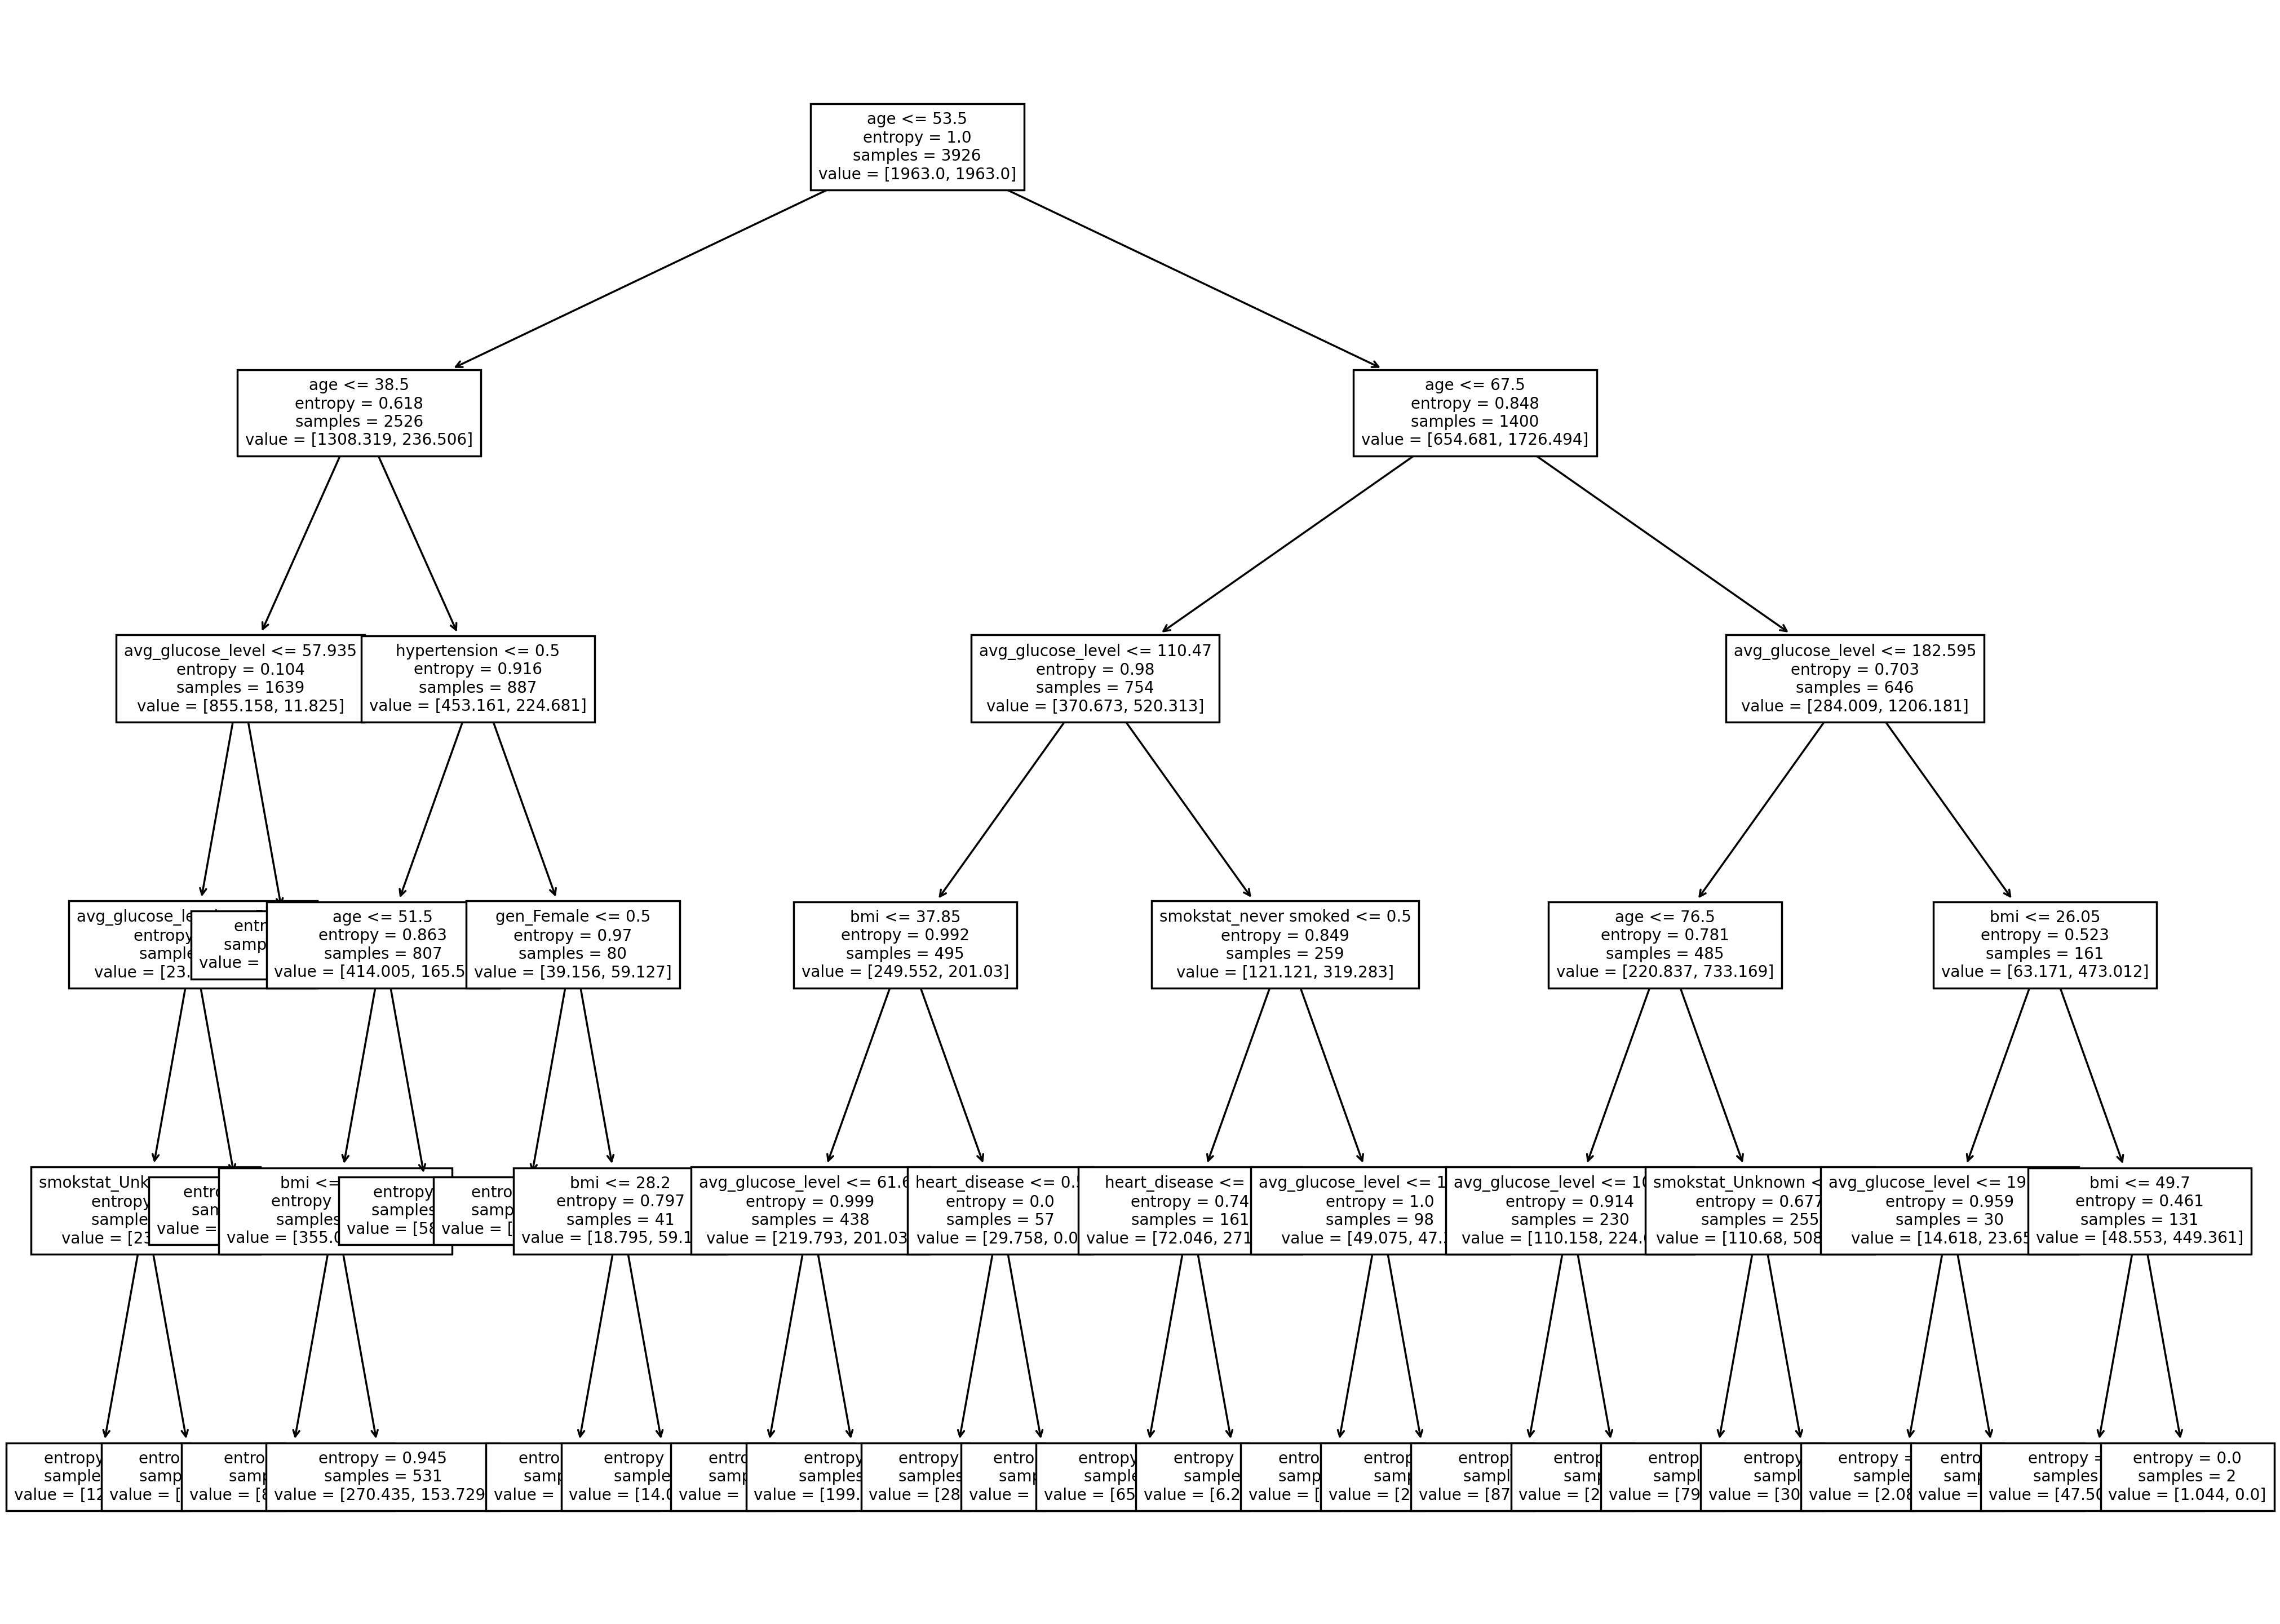

In [ ]:
plt.figure(figsize=(20,15), dpi=250)
plot_tree(dtc, feature_names=X.columns, fontsize=8)
plt.show()

La siguiente figura proporciona una visualización de la importancia de los features en el modelo.

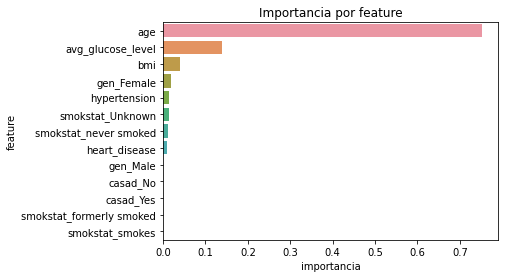

In [ ]:
feat_names = [i for i in X_train]
feat_import_df_dtc = pd.DataFrame(
    {'importancia': dtc.feature_importances_, 
    'feature'      : feat_names}).sort_values('importancia', ascending=False)
fig2 = sns.barplot(data=feat_import_df_dtc, x= feat_import_df_dtc['importancia'],y=feat_import_df_dtc['feature'])
plt.title("Importancia por feature")
plt.show(fig2)

In [ ]:
pd.DataFrame(dtc.feature_importances_, index=X.columns, columns=['valor'])

,valor
age,7.040263e-01
hypertension,1.554641e-02
heart_disease,0.000000e+00
avg_glucose_level,1.135589e-01
bmi,1.068402e-01
gen_Female,4.012232e-02
gen_Male,0.000000e+00
casad_No,4.673850e-17
casad_Yes,0.000000e+00
smokstat_Unknown,0.000000e+00


La tabla muestra la importancia de cada `feature`, en definitiva, la edad `age` corresponda a la vairable de mayor importancia, seguido luego por el `bmi` y `avg_glucose_level`.

### Modelo Random Forest
Repitamos el análisis anterior pero ahora con un Random Forest. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Construcción del clasificador Random Forest
rfc = RandomForestClassifier(n_estimators=500, criterion='entropy',  class_weight='balanced', max_depth=4)
rfc.fit(X_train, y_train)
feature_importance = rfc.feature_importances_ 
y_pred_rtc = rfc.predict(X_test)
print(classification_report(y_test, y_pred_rtc))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       939
           1       0.10      0.70      0.18        43

    accuracy                           0.71       982
   macro avg       0.54      0.71      0.50       982
weighted avg       0.94      0.71      0.80       982



En cuanto a las métricas del modelo, no es mejor que el decision tree. Consideramos que se debe a las mismas causas que en el caso anterior, sumado a que el random forest está compuesto por un ensamble de decision tree de los cuales todos esos están sesgado hacia las personas sin ACV.

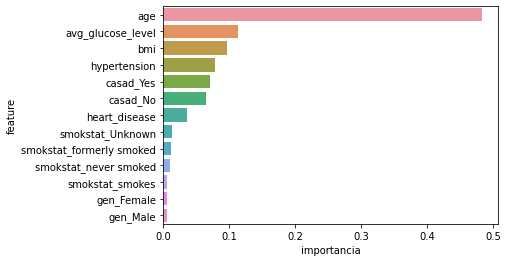

In [ ]:
feat_import_df_rfc = pd.DataFrame(
    {'importancia': rfc.feature_importances_, 
      'feature': feat_names}).sort_values('importancia', ascending=False)
sns.barplot(data=feat_import_df_rfc, x= feat_import_df_rfc['importancia'],y=feat_import_df_rfc['feature'])

Si bien la edad, el nivel de glucosa y el bmi sigue siendo los features más importantes, en este caso el modelo considera que el estado civil también juega un rol a la hora de predecir. No obstante, cabe destacar que el estado civil es una variable correlacionada a la edad, por lo que su importancia se deba, en realidad, a la edad de la persona.

In [ ]:
pd.DataFrame(rfc.feature_importances_, index=X.columns, columns=['valor'])

,valor
age,0.483235
hypertension,0.079240
heart_disease,0.036148
avg_glucose_level,0.113027
bmi,0.096223
gen_Female,0.006290
gen_Male,0.005931
casad_No,0.064869
casad_Yes,0.071190
smokstat_Unknown,0.014112


**Conclusión**

Notamos que en los dos modelos, la edad es buen predictor de riesgo de ACV. En el caso del Decicision Tree, pudimos notar que si la edad de la persona es menor a 42.5, el modelo le asignará una menor probabilidad de ACV. Esto corresponde con la figura que muestra la estimación de distribución de ACV, dado que se observa que, para los individuos con ACV, la distribución está concentrada en los 40 años en adelante. 

## Experimento 5: El género es un predictor de ACV según el rango etario
Como habiamos dicho queremos ver si el género del paciente varía en importancia según la edad. Es decir, cómo varía el peso que nuestro modelo le da a las features de género en funcion del grupo etario.


Como otra motivacion fue que la densidad de personas que tuvieron un ACV es claramente mayor con mujeres jóvenes que con hombres jóvenes. Sin embargo a mayor edad se "equiparan".

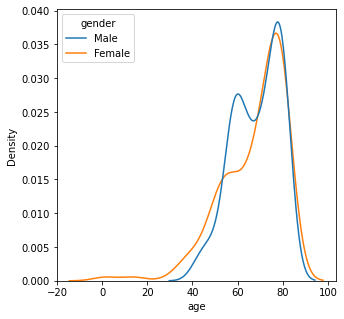

In [ ]:
dfStroke = df[df.stroke == 1]
sns.kdeplot(data=dfStroke, x='age', hue='gender', common_norm= False)


Los grupos etarios que definimos fueron de 0-33, 33-50, 50-64 y 64 en adelante.

La razón por la cual elegimos estas edades fue para garantizar que en cada grupo etario al menos 2 personas hayan tenido un ACV y a su vez que todos tengan al menos mil datos. 

In [ ]:
df = pd.read_csv(
    DATA_HOME + "/healthcare-dataset-stroke-data.csv"
)
df = df[df.gender != "Other"]
df = df[df['bmi'].notna()]
df = df.drop(["work_type",	"Residence_type"], axis=1)
categoricas = ["gender", "ever_married","smoking_status"]
dfEncodeada = pd.get_dummies(df, columns=categoricas, prefix=["gen","casad","smokstat"] )
dfEncodeada = dfEncodeada.loc[:, dfEncodeada.columns != "id"]
jovenes = dfEncodeada.loc[dfEncodeada.age<33,:]
adultosJovenes = dfEncodeada.loc[dfEncodeada.age>=33,:]
adultosJovenes = adultosJovenes.loc[adultosJovenes.age<50,:]
adultosSeniors = dfEncodeada.loc[dfEncodeada.age>=50,:]
adultosSeniors = adultosSeniors.loc[adultosSeniors.age<64,:]
adultosMayores = dfEncodeada.loc[dfEncodeada.age>=64,:]


xdfJov = jovenes.loc[:, jovenes.columns != "stroke"]
ydfJov = jovenes["stroke"]

xdfAduJov = adultosJovenes.loc[:, adultosJovenes.columns != "stroke"]
ydfAduJov = adultosJovenes["stroke"]

xdfAduSen = adultosSeniors.loc[:, adultosSeniors.columns != "stroke"]
ydfAduSen = adultosSeniors["stroke"]

xdfAduMay = adultosMayores.loc[:, adultosMayores.columns != "stroke"]
ydfAduMay = adultosMayores["stroke"]

xGrupoEtario = [xdfJov, xdfAduJov, xdfAduSen,xdfAduMay]
yGrupoEtario = [ydfJov, ydfAduJov, ydfAduSen,ydfAduMay]
print(jovenes.shape)
print(adultosJovenes.shape)
print(adultosSeniors.shape)
print(adultosMayores.shape)

(1678, 14)
(1140, 14)
(1085, 14)
(1005, 14)


Luego de dividir por edad, ahora a cada edad debemos partirla en Train y Test. La proporción elegida para test fue de 1/4 asi nos quedan más de 750 filas para cada etapa de entrenamiento y al menos 250 para cada etapa de testeo.
A su vez, usamos la division estratificada para que no me queden pocas observaciones de ACV en alguno de los 2 grupos.

In [ ]:
dataXTrain = [[],[],[],[]]
dataXDev = [[],[],[],[]]
dataYTrain = [[],[],[],[]]
dataYDev = [[],[],[],[]]
for j in range(0,len(xGrupoEtario)):
  dataXTrain[j], dataXDev[j], dataYTrain[j], dataYDev[j] = train_test_split(xGrupoEtario[j], yGrupoEtario[j],
                                                    stratify=yGrupoEtario[j], 
                                                    test_size=1/4)

### Eligiendo la mínima cantidad de hojas para evitar hacer overfitting

In [ ]:
complexity = [[],[],[],[]]
tr_err = [[],[],[],[]]
te_err = [[],[],[],[]]
cantidadFiteos = 20
sumaImportancia = np.zeros(( len(xGrupoEtario),len(xGrupoEtario[0].columns)))
for j in range(0,len(xGrupoEtario)):
  for i in range(1,cantidadFiteos):
      model = DecisionTreeRegressor(min_samples_leaf=i).fit(dataXTrain[j], dataYTrain[j])
      complexity[j].append(i) #model.get_n_leaves()
      tr_err[j].append(math.sqrt(mean_squared_error(dataYTrain[j], model.predict(dataXTrain[j]))))
      te_err[j].append(math.sqrt(mean_squared_error(dataYDev[j], model.predict(dataXDev[j]))))
      sumaImportancia[j] = sumaImportancia[j] + model.feature_importances_

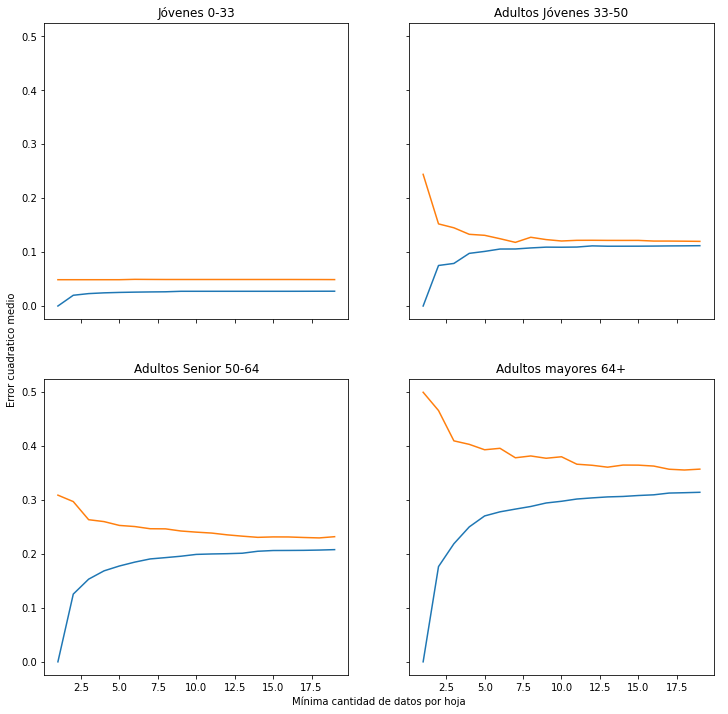

In [ ]:
plt.rcParams["figure.figsize"] = (12,12)

figure, axis = plt.subplots(2, 2, sharex= True, sharey=True)
figure.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Mínima cantidad de datos por hoja")
plt.ylabel("Error cuadratico medio")

#Para  Jovenes
axis[0, 0].plot(complexity[0], tr_err[0], label='training error')
axis[0, 0].plot(complexity[0], te_err[0], label='test error')
axis[0, 0].set_title("Jóvenes 0-33")
  
# Para Adultos Jovenes
axis[0, 1].plot(complexity[1], tr_err[1], label='training error')
axis[0, 1].plot(complexity[1], te_err[1], label='test error')
axis[0, 1].set_title("Adultos Jóvenes 33-50")
  
# Para Adultos Seniors
axis[1,0].plot(complexity[2], tr_err[2], label='training error')
axis[1,0].plot(complexity[2], te_err[2], label='test error')
axis[1,0].set_title("Adultos Senior 50-64")
  
# Para Adultos Mayores
axis[1,1].plot(complexity[3], tr_err[3], label='training error')
axis[1,1].plot(complexity[3], te_err[3], label='test error')
axis[1,1].set_title("Adultos mayores 64+")

# Combine all the operations and display
plt.show()

Como vimos en los gráficos, la ventana óptima de mínima cantidad de hojas esta entre 3 y 5 aproximadamente en todos los grupos etarios, asi que fijaremos en 4 la mínima cantidad de hojas para luego mirar la relevancia.

#### Observando cuáles son las features más significativas

In [ ]:
tr_err = [[],[],[],[]]
te_err = [[],[],[],[]]
sumaImportancia = np.zeros(( len(xGrupoEtario),len(xGrupoEtario[0].columns)))

for j in range(0,len(xGrupoEtario)):
    model = DecisionTreeRegressor(min_samples_leaf=4).fit(dataXTrain[j], dataYTrain[j]) #min_samples_leaf=i
    tr_err[j].append(math.sqrt(mean_squared_error(dataYTrain[j], model.predict(dataXTrain[j]))))
    te_err[j].append(math.sqrt(mean_squared_error(dataYDev[j], model.predict(dataXDev[j]))))
    sumaImportancia[j] = sumaImportancia[j] + model.feature_importances_

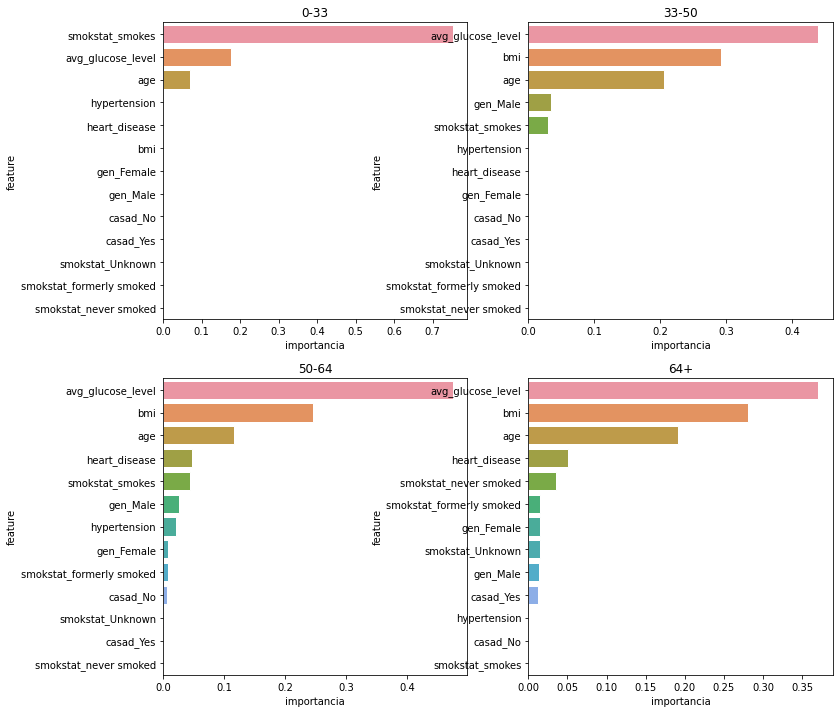

In [ ]:
titulos = ["0-33", "33-50", "50-64","64+"]
fig, ax =plt.subplots(2,2)
sns.set(rc={'figure.figsize':(27.7,5.27)})
for j in range(0,len(xGrupoEtario)):
  feat_import_df_rfc = pd.DataFrame(
      {'importancia': sumaImportancia[j], 
        'feature': dataXTrain[j].columns}).sort_values('importancia', ascending=False)
  if(j<2):
    i = 0
  else:
    i=1
  sns.barplot(data=feat_import_df_rfc, x= feat_import_df_rfc['importancia'],y=feat_import_df_rfc['feature'] , ax = ax[i,j%2]).set(title=titulos[j])

Lo que podemos ver es que las más importantes, a través de los grupos etarios, son los niveles de glucosa promedio, el índice de de masa corporal y la edad. 

Ahora la pregunta es, ¿y el género? ¿Cómo varía?

Text(0, 0.5, 'Relevancia de feature')

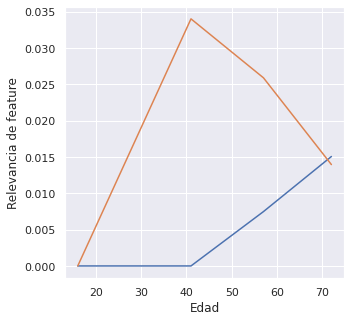

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
mas =[]
fem = []
grupos = [16,41,57,72] # Centro de intervalos de edades
for j in range(0,len(xGrupoEtario)):
  fem.append(sumaImportancia[j][5])
  mas.append(sumaImportancia[j][6])
plt.plot(grupos, fem, label='Mujeres')
plt.plot(grupos, mas, label='Hombres')
plt.xlabel('Edad')
plt.ylabel('Relevancia de feature')

Las 2 features que nos representan género siempre están muy acotadas siendo poco relevantes y más aún según como cortes estratificadamente el dataset podés obtener resultados distintos. Es decir, a veces parece que el género es más importante en adultos jóvenes y a veces figura que es más relevante en adultos mayores.

**Conclusión**

El género si varía en importancia pero de manera muy poco significativa. 